In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import easyocr
import re

from collections import Counter

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
reader       = easyocr.Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [2]:
# Read in both label files
df_train = pd.read_csv(r"C:\Users\wilpo\OneDrive\Documents\MIDS\w210\ifood-2019-fgvc6\train_labels.csv")
df_val   = pd.read_csv(r"C:\Users\wilpo\OneDrive\Documents\MIDS\w210\ifood-2019-fgvc6\val_labels.csv")

In [3]:
# Class list
class_list_path = r"C:\Users\wilpo\OneDrive\Documents\MIDS\w210\ifood-2019-fgvc6\class_list.txt"
class_mapping = {}

# Open the file and read the contents
with open(class_list_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        # Split each line by space to separate the index and the class name
        index, class_name = line.strip().split(' ', 1)
        # Convert the index to an integer and add the mapping to the dictionary
        class_mapping[int(index)] = class_name

In [4]:
# Join the datasets to class list
df_train['category_name'] = df_train['label'].map(class_mapping)
df_val['category_name']   = df_val['label'].map(class_mapping)

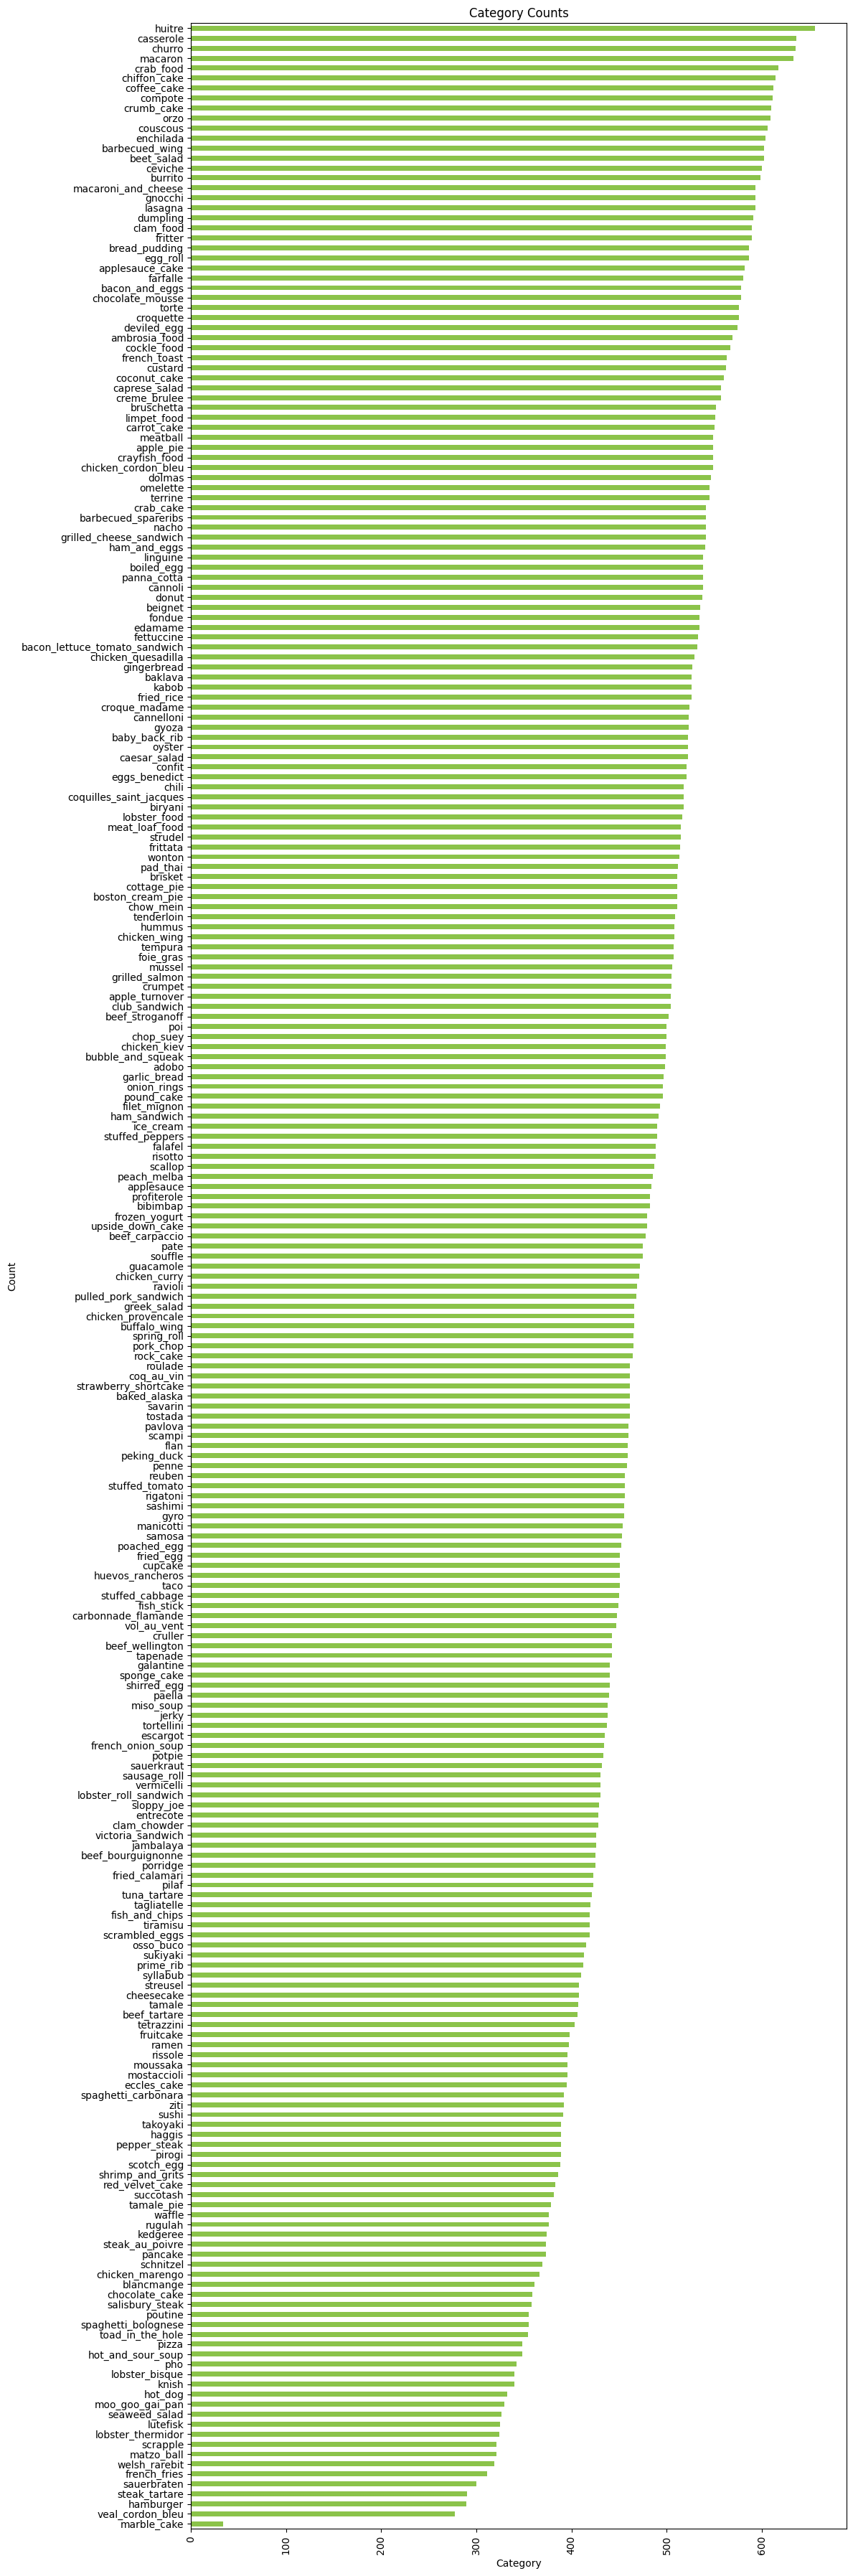

In [5]:
# Display counts for training distribution
category_counts = df_train['category_name'].value_counts()
plt.figure(figsize=(12,36))
category_counts.sort_values(ascending=True).plot(kind='barh', color='#8bc34aff')
plt.title('Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()

# Display the plot
plt.show()

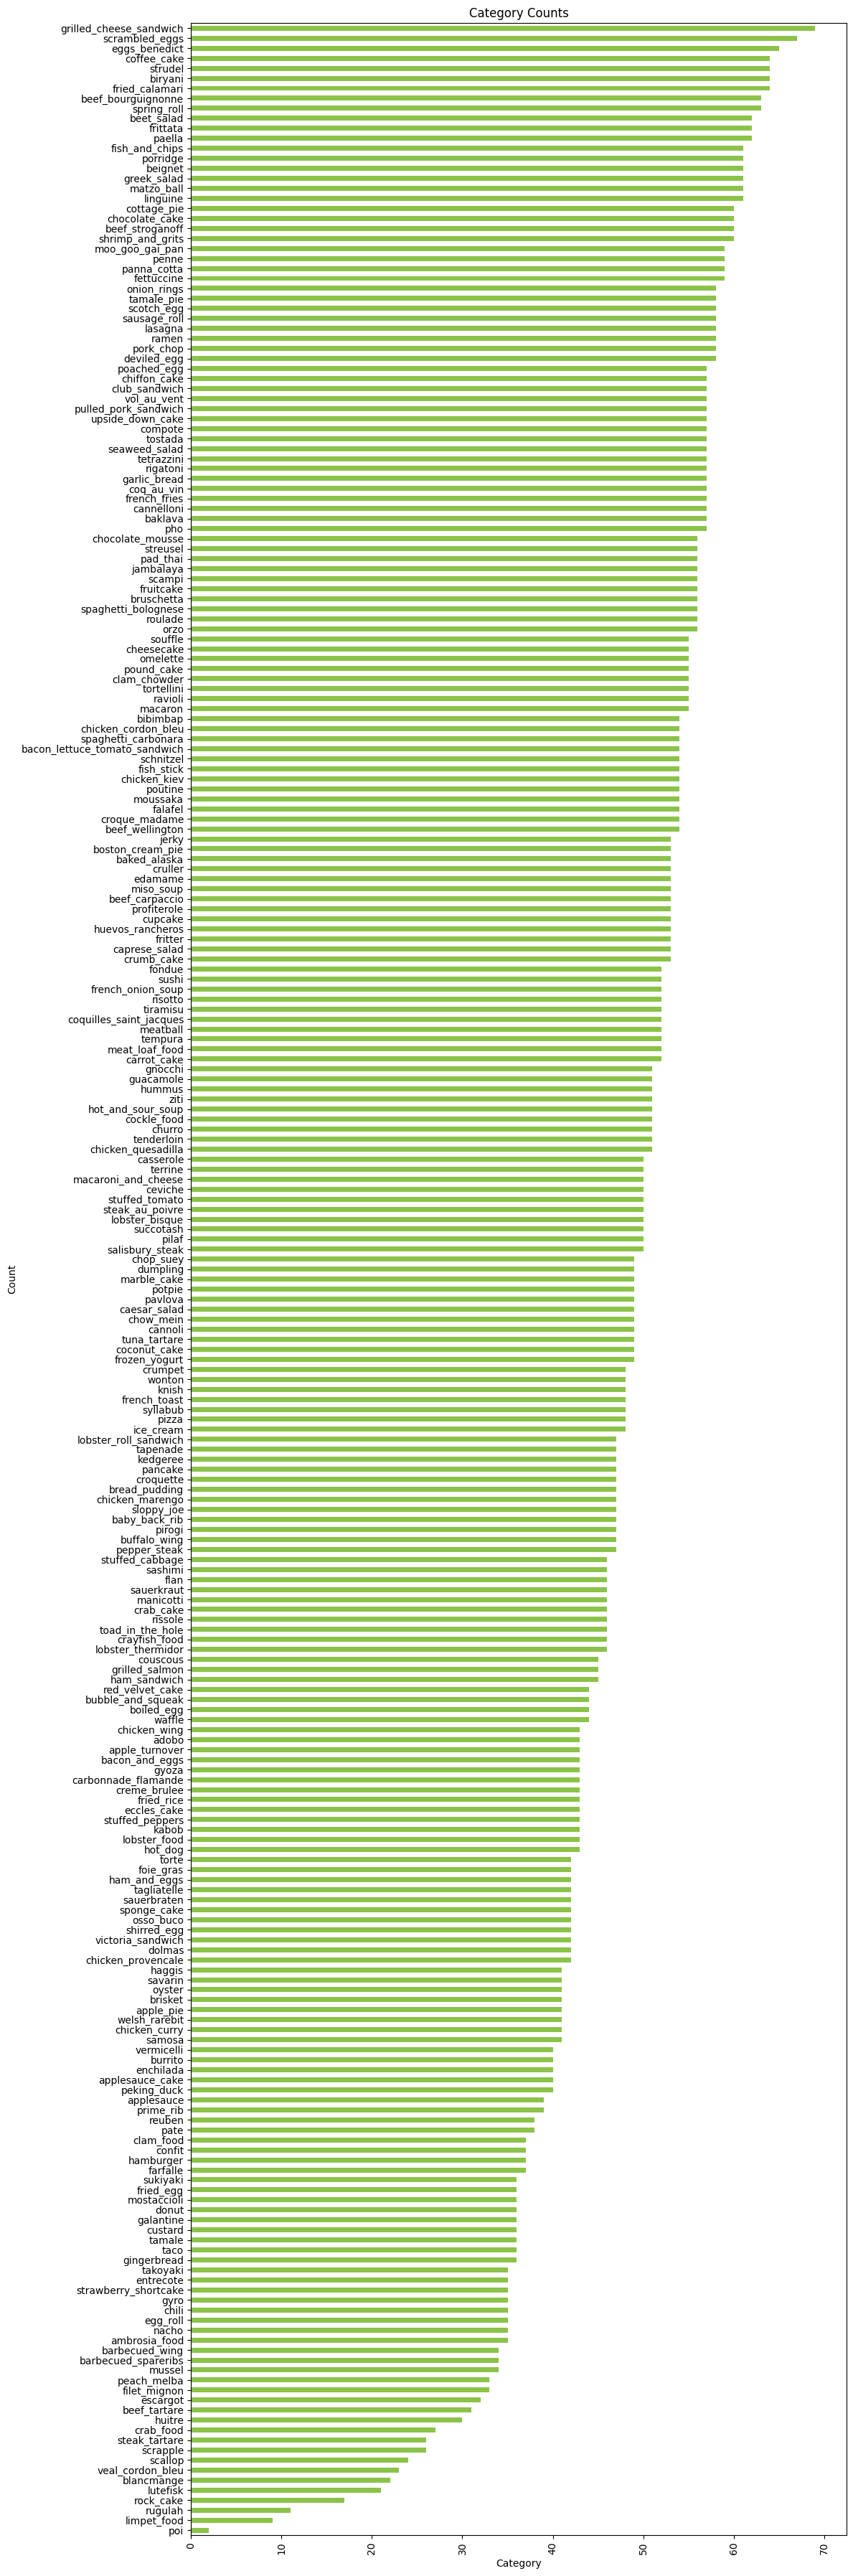

In [6]:
# Display counts for validation distribution
category_counts = df_val['category_name'].value_counts()
plt.figure(figsize=(12,36))
category_counts.sort_values(ascending=True).plot(kind='barh', color='#8bc34aff')
plt.title('Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()

# Display the plot
plt.show()

In [11]:
# Detect for Face
def find_face(img_path):
    image      = cv2.imread(img_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces      = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    return len(faces) > 0

# Detect for Cartoon
def find_cartoon(img_path, contrast_factor = 2000.0):
    image      = cv2.imread(img_path)
    lab        = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b    = cv2.split(lab)
    clahe      = cv2.createCLAHE(clipLimit=contrast_factor, tileGridSize=(8, 8))
    cl         = clahe.apply(l)
    limg       = cv2.merge((cl, a, b))
    contrast_im= cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    pixels     = contrast_im.reshape(-1, contrast_im.shape[-1])
    pixels_tups= [tuple(pixel) for pixel in pixels]
    unique_clrs= Counter(pixels_tups)

    # Optional Component to show the image:
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image)

    return len(unique_clrs) < 25000 or len(unique_clrs) > 50000 # Cartoons either have not enough colour variation (B&W Comics) or too much (Video Games)

# Detect for Text
def find_text(image_path):
    results    = reader.readtext(image_path, detail=0)
    text       = " ".join(results)
    words      = re.findall(r'\b\w+\b', text.lower())
    word_count = Counter(words)

    return len(word_count) > 3

# Detect for Media Art
def find_media_art(image_path, tolerance=0.05):
    image      = cv2.imread(image_path)
    h, w       = image.shape[:2]
    min_w      = w * (1 - tolerance)
    max_w      = w * (1 + tolerance)
    
    return min_w <= h <= max_w

In [13]:
# Test Images
img_path = r"C:\Users\wilpo\OneDrive\Documents\MIDS\w210\ifood-2019-fgvc6\train_set\train_set\train_104721.jpg" # Normal Beef
img_path = r"C:\Users\wilpo\OneDrive\Documents\MIDS\w210\ifood-2019-fgvc6\train_set\train_set\train_105153.jpg" # Dude at fish market
img_path = r"C:\Users\wilpo\OneDrive\Documents\MIDS\w210\ifood-2019-fgvc6\train_set\train_set\train_105520.jpg" # A bunch of text
img_path = r"C:\Users\wilpo\OneDrive\Documents\MIDS\w210\ifood-2019-fgvc6\train_set\train_set\train_080745.jpg" # Cartoon snail
img_path = r"C:\Users\wilpo\OneDrive\Documents\MIDS\w210\ifood-2019-fgvc6\train_set\train_set\train_021413.jpg" # Cartoon game character
img_path = r"C:\Users\wilpo\OneDrive\Documents\MIDS\w210\ifood-2019-fgvc6\train_set\train_set\train_001223.jpg" # Comic strip
img_path = r"C:\Users\wilpo\OneDrive\Documents\MIDS\w210\ifood-2019-fgvc6\train_set\train_set\train_001189.jpg" # Video game screen shot
img_path = r"C:\Users\wilpo\OneDrive\Documents\MIDS\w210\ifood-2019-fgvc6\train_set\train_set\train_075591.jpg" # Album cover/Social media post

find_media_art(img_path)

False